In [ ]:
!pip install tensorflow opencv-python matplotlib

In [9]:
import tensorflow as tf
import os

# 1. Gives a list of gpus to choose so that we can run the Model on GPU

In [10]:
gpus=tf.config.experimental.list_physical_devices('GPU')


In [11]:
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)


# 2. Dataset

In [12]:
!pip install kaggle

In [13]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [14]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

 93% 14.0M/15.1M [00:01<00:00, 18.7MB/s]
100% 15.1M/15.1M [00:01<00:00, 13.5MB/s]


In [ ]:
!unzip /content/brain-mri-images-for-brain-tumor-detection.zip

In [16]:
import shutil
shutil.rmtree('/content/no')
shutil.rmtree('/content/yes')

In [17]:
import cv2
import imghdr
import matplotlib.pyplot as plt

In [18]:
data_dir="/content/brain_tumor_dataset"

In [19]:
image_exts=['jpeg','jpg','JPG','bmp','png'] #acceptable image formats

In [ ]:
os.listdir(os.path.join(data_dir,'yes')) #helps us get all files in a folder

Removing images that are not acceptable under the list of extensions

In [21]:
for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir,image_class)):
    image_path=os.path.join(data_dir,image_class,image)
    try:
      img=cv2.imread(image_path)
      tip=imghdr.what(image_path)
      if tip not in image_exts:
        print("Image: {} not in list of accepted extensions".format(image_path))
        os.remove(image_path)
    except Exception as e:
      print("Issue with Image: {}".format(image_path))

Image: /content/brain_tumor_dataset/no/no 4.jpg not in list of accepted extensions
Image: /content/brain_tumor_dataset/no/N3.jpg not in list of accepted extensions
Image: /content/brain_tumor_dataset/yes/Y46.jpg not in list of accepted extensions


Displaying the image

In [22]:
img=cv2.imread("/content/brain_tumor_dataset/yes/Y1.jpg")

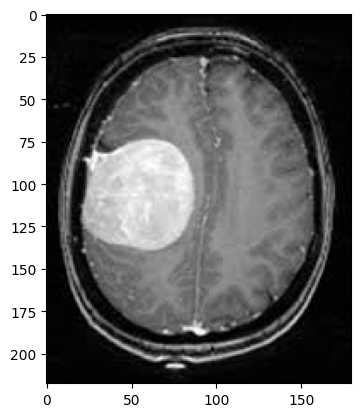

In [23]:
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

# 3. Load Data

In [24]:
import numpy as np

Building a data pipeline. Tensorflow gives an inbuilt function to build data pipelines instead of manually creating labels for the classes, it does it on its own and also does some level of pre processing on the images.

In [25]:
tf.keras.utils.image_dataset_from_directory

<function keras.utils.image_dataset.image_dataset_from_directory(directory, labels='inferred', label_mode='int', class_names=None, color_mode='rgb', batch_size=32, image_size=(256, 256), shuffle=True, seed=None, validation_split=None, subset=None, interpolation='bilinear', follow_links=False, crop_to_aspect_ratio=False, **kwargs)>

In [26]:
data=tf.keras.utils.image_dataset_from_directory('/content/brain_tumor_dataset')

Found 250 files belonging to 2 classes.


In [27]:
data_iterator=data.as_numpy_iterator()

Note that each batch has 32 images with the image_size=(256,256) because of the inbuilt operator we are using

In [28]:
batch=data_iterator.next()

In [29]:
len(batch)#classifies as the images and their labels

2

In [30]:
batch[0].shape #this is the shape of the resized image array done by the inbuilt function

(32, 256, 256, 3)

In [31]:
batch[1] #this is the label assigned automatically to the images of each batch

array([1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0], dtype=int32)

We can see that the inbuilt function assigned 0 to the no and 1 to the yes classes of the dataset

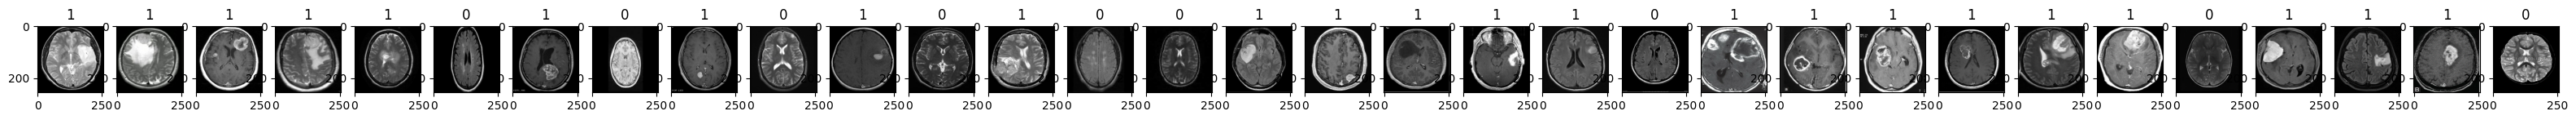

In [32]:
fig, ax = plt.subplots(ncols=32, figsize=(40,40))
for idx, img in enumerate(batch[0][:32]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

#4. Preprocess data

Scaling the data

In [33]:
batch[0].min(),batch[0].max() #this is the minimum and maximum values of the image arrays in the batch.
#we want to reduce it to the range of 0 and 1 to enable faster processing.
#Hence we scale the images to 0 and 1

(0.0, 255.0)

In [34]:
data=data.map(lambda x,y: (x/255,y)) #x are the images and y are the labels

In [35]:
data.as_numpy_iterator().next()[0].min(),data.as_numpy_iterator().next()[0].max()

(0.0, 1.0)

Splitting data

In [36]:
len(data)

8

In [37]:
train_size=int(len(data)*0.7)
val_size=int(len(data)*0.2)+1
test_size=int(len(data)*0.1)+1

In [38]:
train_size,val_size,test_size

(5, 2, 1)

In [39]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 5. Neural Network

Learn about different types of layers in the neural network

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [41]:
model=Sequential()

In [42]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

For binary classification we use the loss function as binary cross entropy and for multi-class classification we can use the loss function categorical cross entropy

In [43]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [47]:
logdir='logs'
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [49]:
hist=model.fit(train,epochs=10,validation_data=val,callbacks=[tensorboard_callback])

Epoch 1/10
5/5 [==============================] - 17s 204ms/step - loss: 0.9924 - accuracy: 0.5938 - val_loss: 0.6382 - val_accuracy: 0.6719
Epoch 2/10
5/5 [==============================] - 1s 202ms/step - loss: 0.5594 - accuracy: 0.7875 - val_loss: 0.5351 - val_accuracy: 0.7344
Epoch 3/10
5/5 [==============================] - 1s 201ms/step - loss: 0.4952 - accuracy: 0.8062 - val_loss: 0.4443 - val_accuracy: 0.8125
Epoch 4/10
5/5 [==============================] - 1s 150ms/step - loss: 0.4293 - accuracy: 0.7937 - val_loss: 0.5036 - val_accuracy: 0.7656
Epoch 5/10
5/5 [==============================] - 1s 151ms/step - loss: 0.4377 - accuracy: 0.8250 - val_loss: 0.3383 - val_accuracy: 0.8750
Epoch 6/10
5/5 [==============================] - 1s 149ms/step - loss: 0.3912 - accuracy: 0.8500 - val_loss: 0.3144 - val_accuracy: 0.9062
Epoch 7/10
5/5 [==============================] - 1s 149ms/step - loss: 0.3455 - accuracy: 0.8938 - val_loss: 0.3014 - val_accuracy: 0.8438
Epoch 8/10
5/5 [===

#6. Peformance Evaluation

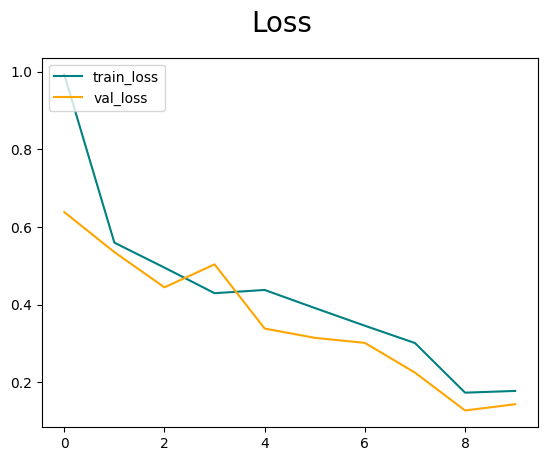

In [52]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='train_loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()


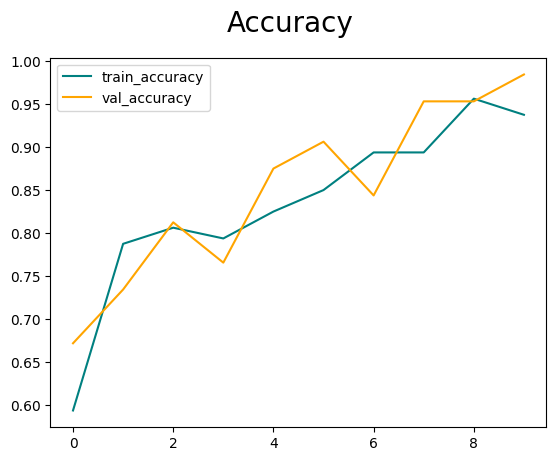

In [53]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='train_accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [54]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [55]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [56]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 440ms/step


In [57]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.9230769, shape=(), dtype=float32) tf.Tensor(0.96153843, shape=(), dtype=float32)


#7. Testing

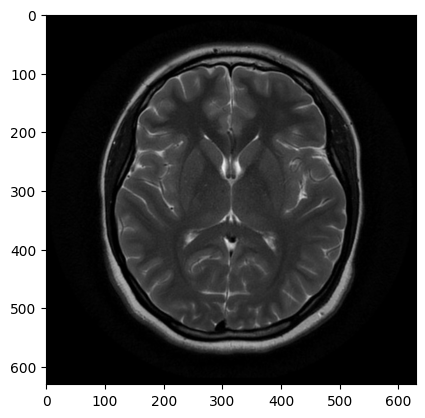

In [71]:
test_image2=cv2.imread("/content/brain_tumor_dataset/no/1 no.jpeg")
plt.imshow(test_image2)


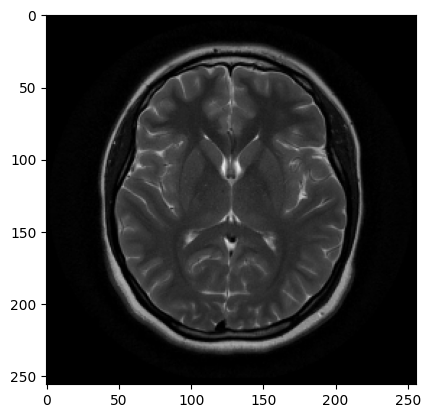

In [73]:
resized_image2=tf.image.resize(test_image2,(256,256))
plt.imshow(resized_image2.numpy().astype(int))
plt.show()

In [74]:
ypred2=model.predict(np.expand_dims(resized_image2/255,0))
if ypred2>0.5:
  print("Tumour is present")
else:
  print("Tumour is absent")

1/1 [==============================] - 0s 34ms/step
Tumour is absent


Tumour is absent


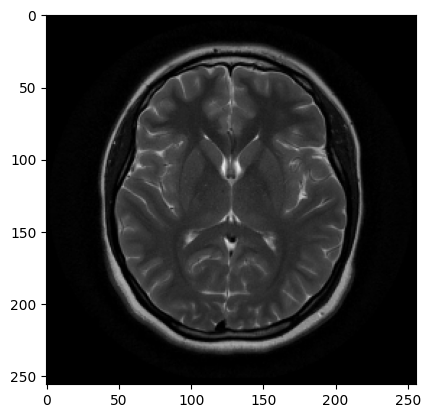

In [76]:
if ypred2>0.5:
  print("Tumour is present")
else:
  print("Tumour is absent")
plt.imshow(resized_image2.numpy().astype(int))
plt.show()

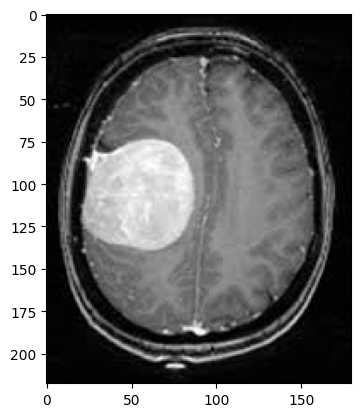

In [58]:
test_image=cv2.imread("/content/brain_tumor_dataset/yes/Y1.jpg")
plt.imshow(test_image)

Tumour is present


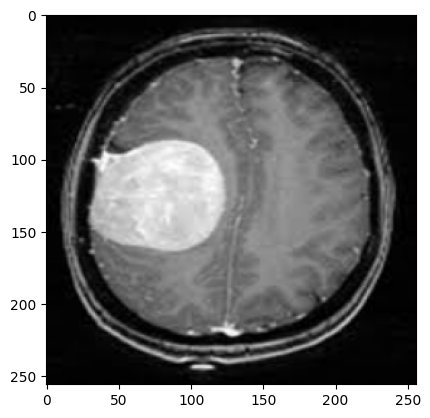

In [70]:
if ypred>0.5:
  print("Tumour is present")
else:
  print("Tumour is absent")
resized_image=tf.image.resize(test_image,(256,256))
plt.imshow(resized_image.numpy().astype(int))
plt.show()

In [62]:
ypred=model.predict(np.expand_dims(resized_image/255,0))

1/1 [==============================] - 0s 173ms/step


In [63]:
ypred

array([[0.98962307]], dtype=float32)

In [64]:
if ypred>0.5:
  print("Tumour is present")
else:
  print("Tumour is absent")

Tumour is present


#8. Saving the model

In [65]:
from tensorflow.keras.models import load_model

In [66]:
model.save(os.path.join('models','tumourclassifier.h5'))

To load the model to a new variable:

In [67]:
new_model=load_model("/content/models/tumourclassifier.h5")

In [68]:
new_model.predict(np.expand_dims(resized_image/255,0))

1/1 [==============================] - 0s 72ms/step


array([[0.98962307]], dtype=float32)